## 각종 라이브러리를 가져옵니다.

In [2]:
import PIL
from PIL import Image

import csv
import pathlib
import numpy as np
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from typing import Any,Tuple,Optional,Callable


import torch
import torch.nn as nn
from torch.optim import Adam,lr_scheduler
from torch.utils.data import Dataset,DataLoader,random_split
from torchvision.transforms.v2 import ToTensor, Resize, Compose, ColorJitter, RandomRotation, AugMix, RandomCrop, GaussianBlur, RandomEqualize, RandomHorizontalFlip, RandomVerticalFlip


/Users/lsm/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 시드를 고정합니다.

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")
    device = torch.device("cpu")

print(device)



def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(1)

mps


## 커스텀 데이터셋을 정의합니다.

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 7]  # 이미지 경로
        label = self.dataframe.iloc[idx, 6]  # 레이블

        # print(img_path, label)

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

## transforms를 정의합니다.

In [5]:
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor

# 변환 정의
train_transforms = Compose([
    # ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1),
    # RandomEqualize(0.4),
    # AugMix(),
    # RandomHorizontalFlip(0.3),
    # RandomVerticalFlip(0.3),
    # GaussianBlur((3, 3)),
    # RandomRotation(30),
    Resize([32,32]),
    ToTensor(),
])

test_transforms = Compose([
    Resize([32, 32]),
    ToTensor(),
    GaussianBlur((61, 61)),
])

# 데이터셋 생성
train_dataset = CustomImageDataset(csv_file='exp_train.csv', transform=train_transforms)

# 데이터 로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# train_dataset[0]



## 모델을 정의합니다.

In [6]:
class NN(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(NN,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

      
      
        self.metrics = {}
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.l1 = nn.Linear(self.input_dim,50)
        self.l2 = nn.Linear(50,20)
        self.l3 = nn.Linear(20,output_dim)

    def forward(self,input):
        
        flatten = self.flatten(input)
        dense_l1 = self.l1(flatten)
        act_l1 = self.relu(dense_l1) # 50
        dense_l2 = self.l2(act_l1)
        act_l2 = self.relu(dense_l2) # 20
        output = self.l3(act_l2)
        
        return output
    

## 모델을 학습합니다.

In [ ]:
# 모델 학습
INPUT_DIM = 32*32*3
OUTPUT_DIM = 8
model = NN(INPUT_DIM,OUTPUT_DIM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 모델 학습
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy 계산
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / total * 100

        # if (i+1) % 100 == 0:
        #     print (f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')

    # test 데이터에 대해서 accuracy 계산
    # model.eval()
    # with torch.no_grad():
    #     correct = 0
    #     total = 0
    #     for images, labels in test_dataloader:
    #         images = images.to(device)
    #         labels = labels.to(device)
    #         outputs = model(images)
    #         _, predicted = torch.max(outputs.data, 1)
    #         total += labels.size(0)
    #         correct += (predicted == labels).sum().item()

    #     test_accuracy = correct / total * 100

    print (f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')
    scheduler.step()

In [ ]:
# 모델 저장
torch.save(model.state_dict(), 'model.pt')
print('Model saved!')

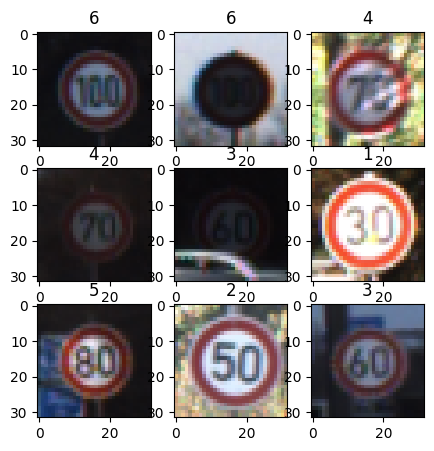

NameError: name 'model' is not defined

In [10]:
# 모델 평가
test_transforms = Compose([
    Resize([32, 32]),
    ToTensor()
])

test_dataset = CustomImageDataset(csv_file='exp_test.csv', transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


plt.figure(figsize=(5,5))
for i in range(1,10):
    input,label = test_dataset[i]
    input = input.permute(1,2,0)
    plt.subplot(3,3,i)
    plt.title(label)
    plt.imshow(input)
plt.show()



model.eval()


with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {total} test images: {100 * correct / total}%')



In [ ]:
# 각 클래스별 정확도 계산
model.eval()

# 각 클래스에 대한 정확한 예측 수를 저장하는 배열
class_correct = list(0. for i in range(8))  # 클래스 수에 따라 변경
class_total = list(0. for i in range(8))  # 클래스 수에 따라 변경

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(len(labels)):  # 배치 크기에 따라 변경
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# 각 클래스별 정확도 출력
for i in range(8):  # 클래스 수에 따라 변경
    print('Accuracy of class %d : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

# 학습이 완료된 모델에 대해서 실험

In [19]:
# test dataset에 대해서 Gaussian Bluring을 늘려가면서 정확도를 측정
INPUT_DIM = 32*32*3
OUTPUT_DIM = 8
path = 'model.pt'

model = NN(INPUT_DIM,OUTPUT_DIM).to(device)
model.load_state_dict(torch.load(path))

model.eval()


# 정확도를 저장할 딕셔너리
accuracy_dict = {i: [] for i in range(8)}  # 클래스 수에 따라 변경

# 가우시안 블러링 최대 레벨 설정 (blur_max * 2 - 1)
blur_max = 9

with torch.no_grad():
    for i in range(1, blur_max + 1):
        blurring_level = i * 10
        print('--------------------------------------------------')
        print(f'Gaussian Blurring Level: {blurring_level}')
        
        blurring_transforms = Compose([
            Resize([32, 32]),
            ToTensor(),
            RandomRotation(blurring_level),
        ])

        blurring_dataset = CustomImageDataset(csv_file='exp_test.csv', transform=blurring_transforms)
        blurring_dataloader = DataLoader(blurring_dataset, batch_size=16, shuffle=False)


        class_correct = list(0. for i in range(8)) 
        class_total = list(0. for i in range(8)) 

        for images, labels in blurring_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()

            for i in range(len(labels)):  # 배치 크기에 따라 변경
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

        # 각 클래스별 정확도 출력
        for i in range(8):  # 클래스 수에 따라 변경
            print('Accuracy of class %d : %2d %%' % (
                i, 100 * class_correct[i] / class_total[i]))
            accuracy_dict[i].append(100 * class_correct[i] / class_total[i])


--------------------------------------------------
Gaussian Blurring Level: 10
Accuracy of class 0 : 33 %
Accuracy of class 1 : 85 %
Accuracy of class 2 : 91 %
Accuracy of class 3 : 80 %
Accuracy of class 4 : 82 %
Accuracy of class 5 : 65 %
Accuracy of class 6 : 62 %
Accuracy of class 7 : 74 %
--------------------------------------------------
Gaussian Blurring Level: 20
Accuracy of class 0 : 15 %
Accuracy of class 1 : 69 %
Accuracy of class 2 : 84 %
Accuracy of class 3 : 71 %
Accuracy of class 4 : 73 %
Accuracy of class 5 : 57 %
Accuracy of class 6 : 51 %
Accuracy of class 7 : 68 %
--------------------------------------------------
Gaussian Blurring Level: 30
Accuracy of class 0 : 13 %
Accuracy of class 1 : 54 %
Accuracy of class 2 : 72 %
Accuracy of class 3 : 61 %
Accuracy of class 4 : 66 %
Accuracy of class 5 : 48 %
Accuracy of class 6 : 39 %
Accuracy of class 7 : 58 %
--------------------------------------------------
Gaussian Blurring Level: 40
Accuracy of class 0 : 11 %
Accuracy 

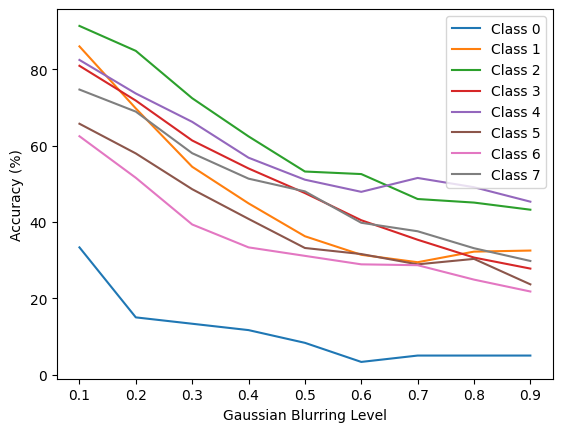

In [21]:
blurring_levels = [i*0.1 for i in range(1, blur_max+1)]
for i in range(8):  # 클래스 수에 따라 변경
    plt.plot(blurring_levels, accuracy_dict[i], label=f'Class {i}')
plt.xlabel('Gaussian Blurring Level')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [ ]:
# test dataset에 대해서 Gaussian Bluring을 늘려가면서 정확도를 측정
INPUT_DIM = 32*32*3
OUTPUT_DIM = 8
path = 'model.pt'

model = NN(INPUT_DIM,OUTPUT_DIM).to(device)
model.load_state_dict(torch.load(path))

model.eval()


# 정확도를 저장할 딕셔너리
accuracy_dict = {i: [] for i in range(8)}  # 클래스 수에 따라 변경

# 가우시안 블러링 최대 레벨 설정 (blur_max * 2 - 1)
blur_max = 20

with torch.no_grad():
    for i in range(1, blur_max):
        blurring_level = i
        print('--------------------------------------------------')
        print(f'Gaussian Blurring Level: {blurring_level}')
        
        blurring_transforms = Compose([
            Resize([32, 32]),
            ToTensor(),
            GaussianBlur((17, 17), sigma=blurring_level),
        ])

        blurring_dataset = CustomImageDataset(csv_file='exp_test.csv', transform=blurring_transforms)
        blurring_dataloader = DataLoader(blurring_dataset, batch_size=16, shuffle=False)


        class_correct = list(0. for i in range(8)) 
        class_total = list(0. for i in range(8)) 

        for images, labels in blurring_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()

            for i in range(len(labels)):  # 배치 크기에 따라 변경
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

        # 각 클래스별 정확도 출력
        for i in range(8):  # 클래스 수에 따라 변경
            print('Accuracy of class %d : %2d %%' % (
                i, 100 * class_correct[i] / class_total[i]))
            accuracy_dict[i].append(100 * class_correct[i] / class_total[i])

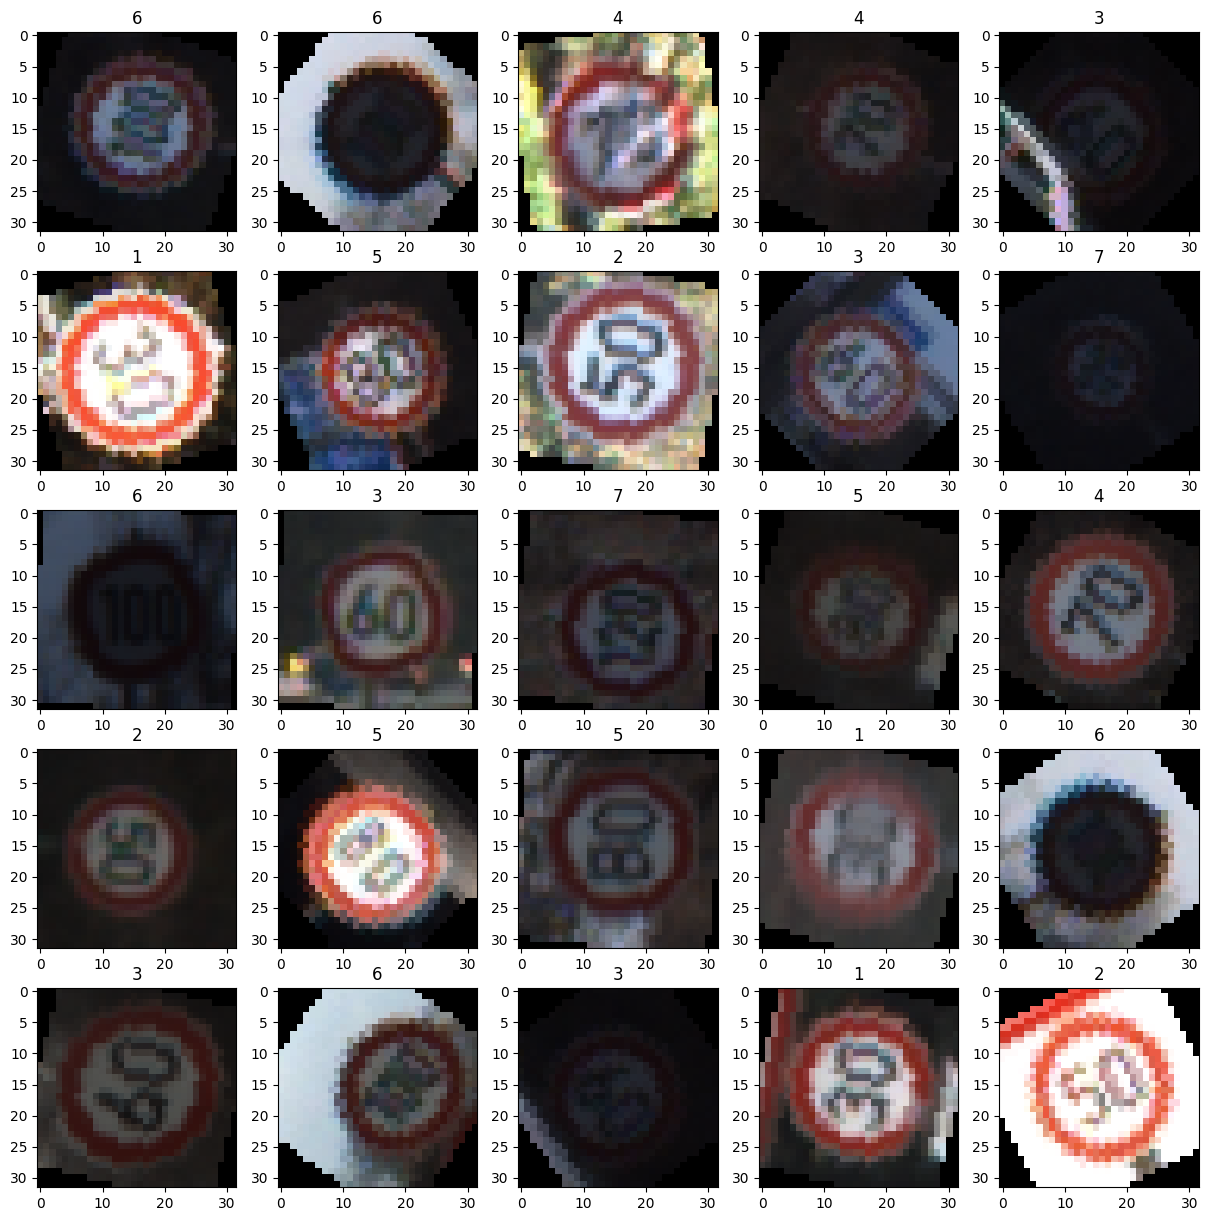

In [20]:
blurring_transforms = Compose([
    Resize([32, 32]),
    ToTensor(),
    RandomRotation(90),
])


blurring_dataset = CustomImageDataset(csv_file='exp_test.csv', transform=blurring_transforms)
blurring_dataloader = DataLoader(blurring_dataset, batch_size=16, shuffle=False)


plt.figure(figsize=(15,15))
for i in range(1,26):
    input,label = blurring_dataset[i]
    input = input.permute(1,2,0)
    plt.subplot(5,5,i)
    plt.title(label)
    plt.imshow(input)

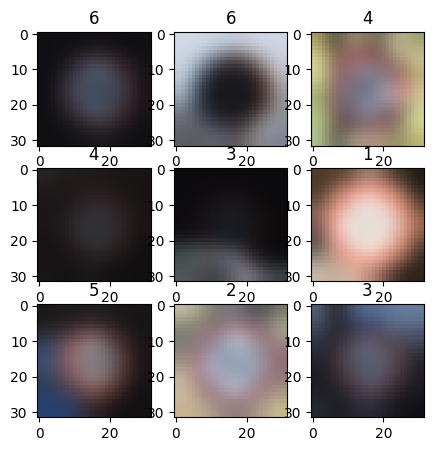

In [33]:
blurring_transforms = Compose([
    Resize([32, 32]),
    ToTensor(),
    GaussianBlur((17, 17), sigma=3),
])

blurring_dataset = CustomImageDataset(csv_file='exp_test.csv', transform=blurring_transforms)
blurring_dataloader = DataLoader(blurring_dataset, batch_size=16, shuffle=False)


plt.figure(figsize=(5,5))
for i in range(1,10):
    input,label = blurring_dataset[i]
    input = input.permute(1,2,0)
    plt.subplot(3,3,i)
    plt.title(label)
    plt.imshow(input)

In [34]:
class SaveActivations:
    def __init__(self):
        self.activations = []

    def __call__(self, module, module_in, module_out):
        self.activations.append(module_out)

    def clear(self):
        self.activations = []

In [93]:
class Custom_7_Dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

        # 레이블 7만 선택
        self.data_frame = self.data_frame[self.data_frame['ClassId'] == 7]
        # print(f'Number of images with label 7: {len(self.data_frame)}')

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_path = self.data_frame.iloc[idx, 7]  # 이미지 경로
        label = self.data_frame.iloc[idx, 6]  # 레이블

        # print(img_path, label)

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label
    
    
blurring_transforms = Compose([
    Resize([32, 32]),
    ToTensor(),
    GaussianBlur((17, 17), sigma=3),
])

# 레이블 7만 포함하는 데이터셋 생성
blurring_dataset_7 = Custom_7_Dataset(csv_file='exp_test.csv', transform=blurring_transforms)
# 레이블 7만 포함하는 데이터 로더 생성
blurring_dataloader_7 = DataLoader(blurring_dataset_7, batch_size=16, shuffle=False)

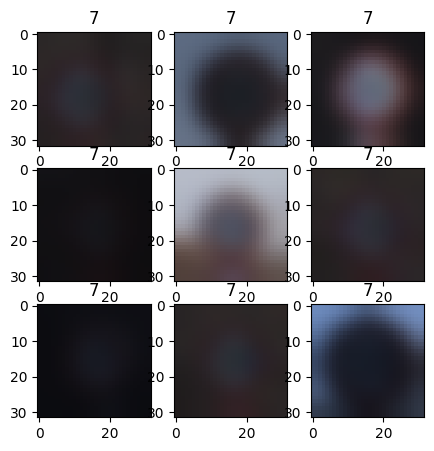

In [74]:
plt.figure(figsize=(5,5))
for i in range(1,10):
    input,label = blurring_dataset_7[i]
    input = input.permute(1,2,0)
    plt.subplot(3,3,i)
    plt.title(label)
    plt.imshow(input)

# 블러링 정도를 다르게 조정해가면서 활성화하는 노드를 확인

### 블러링 주지 않음

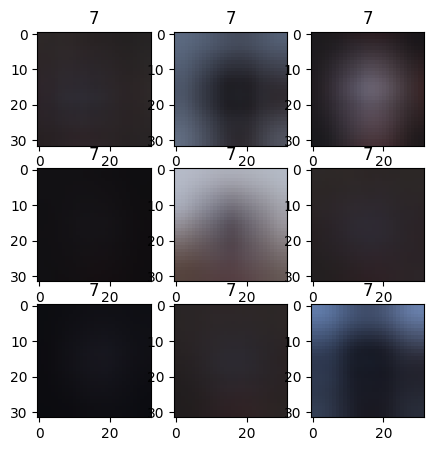

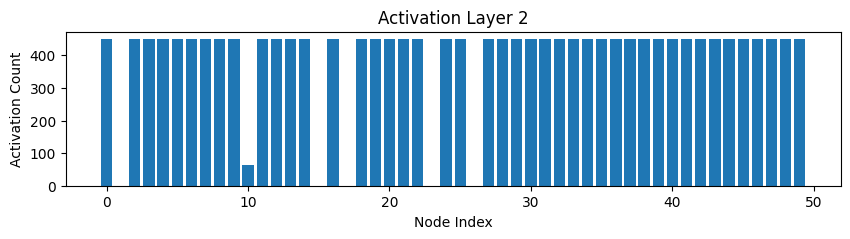

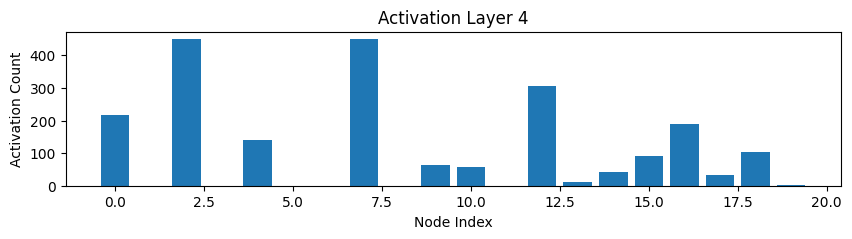

In [121]:
blurring_transforms = Compose([
    Resize([32, 32]),
    ToTensor(),
    GaussianBlur((17, 17), sigma=10),
])

# 레이블 7만 포함하는 데이터셋 생성
blurring_dataset_7 = Custom_7_Dataset(csv_file='exp_test.csv', transform=blurring_transforms)
# 레이블 7만 포함하는 데이터 로더 생성
blurring_dataloader_7 = DataLoader(blurring_dataset_7, batch_size=16, shuffle=False)


plt.figure(figsize=(5,5))
for i in range(1,10):
    input,label = blurring_dataset_7[i]
    input = input.permute(1,2,0)
    plt.subplot(3,3,i)
    plt.title(label)
    plt.imshow(input)


save_activations = SaveActivations()

for name, module in model.named_modules():
    module.register_forward_hook(save_activations)

activation_layer_index = [2, 4]

# 레이어별 활성화 횟수를 저장할 딕셔너리 초기화
activation_counts = {2: [0]*50, 4: [0]*20}

for idx in range(len(blurring_dataset_7)):
    data, label = blurring_dataset_7[idx]
    data = data.unsqueeze(0).to(device)
    output = model(data)

    for i, activation in enumerate(save_activations.activations):
        if i in activation_layer_index:
            zero_elements = (activation == 0)
            zero_indices = torch.nonzero(zero_elements).squeeze()[:, 1].cpu()
            for index in zero_indices:
                activation_counts[i][index] += 1

    # 활성화 클리어
    save_activations.clear()

# 히스토그램 그리기
for i in activation_layer_index:
    plt.figure(figsize=(10,2))
    plt.bar(range(len(activation_counts[i])), activation_counts[i])
    plt.title(f"Activation Layer {i}")
    plt.xlabel("Node Index")
    plt.ylabel("Activation Count")
    plt.show()


### 커널 사이즈: 17 // 표준편차: 1 ~ 10

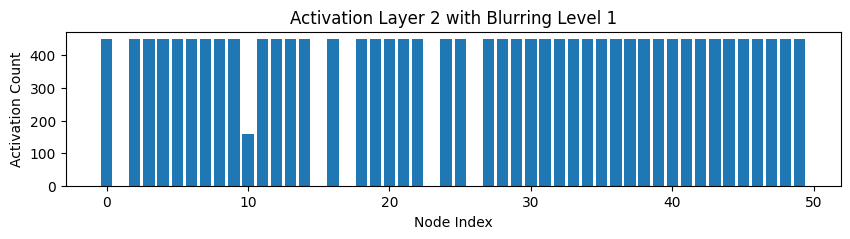

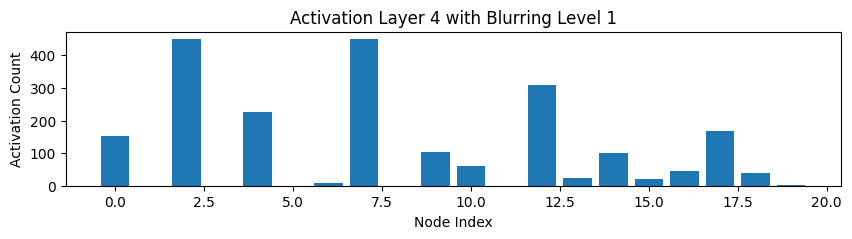

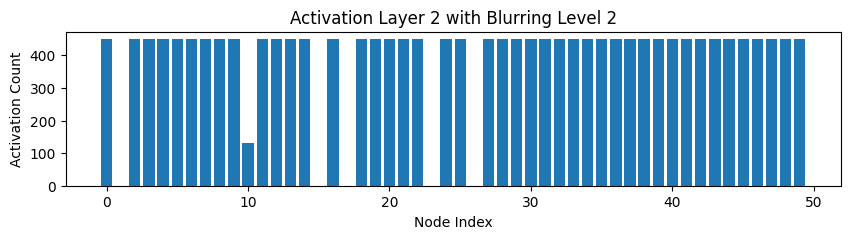

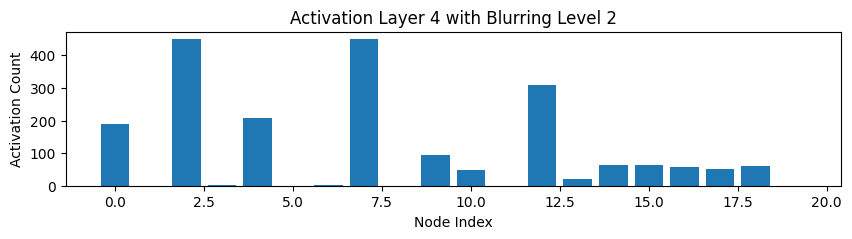

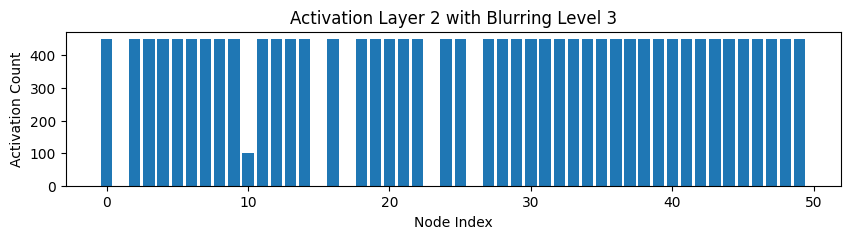

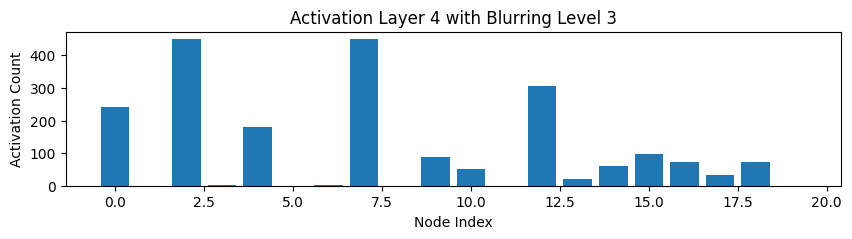

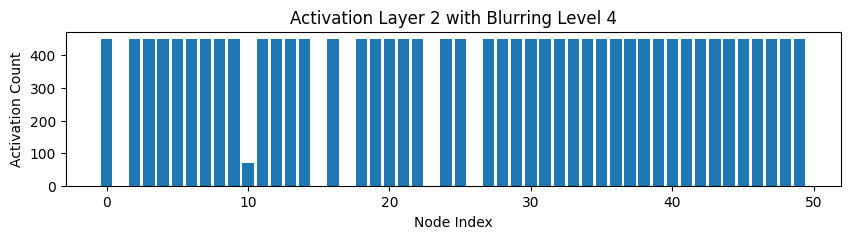

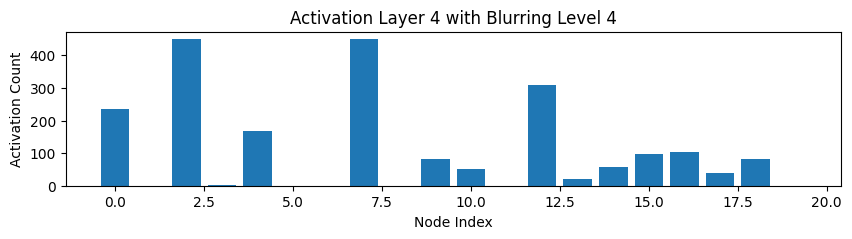

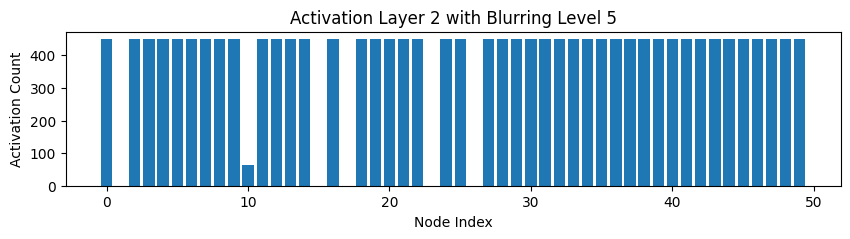

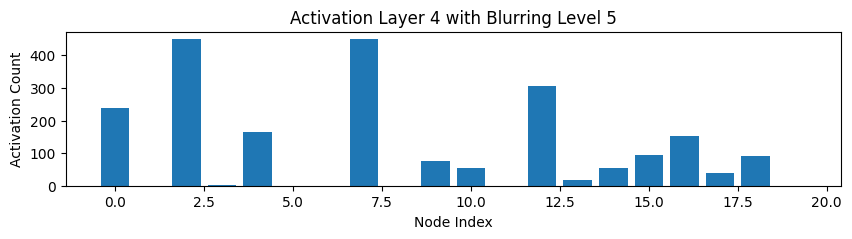

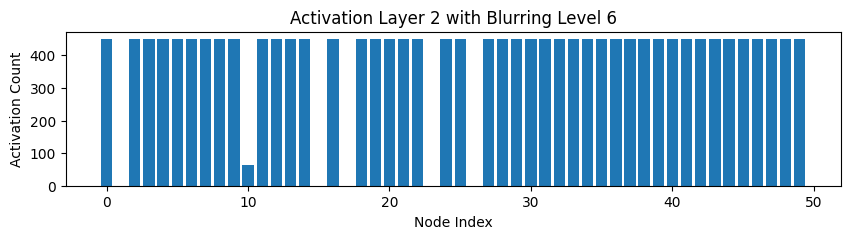

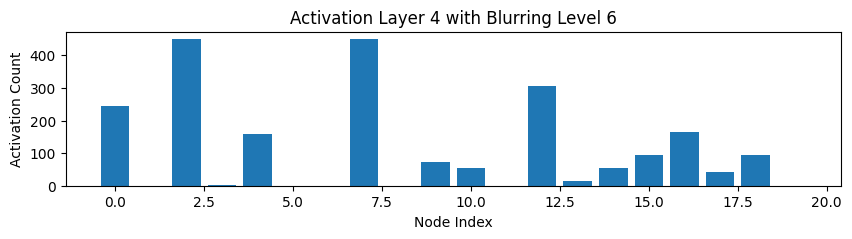

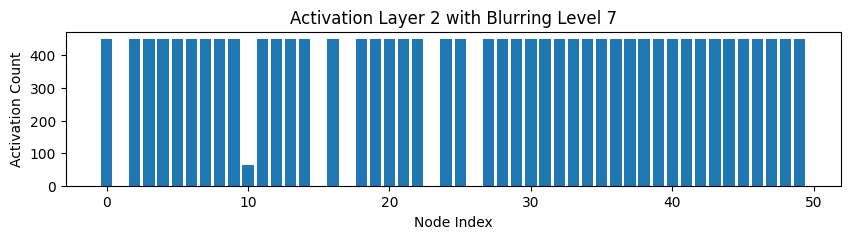

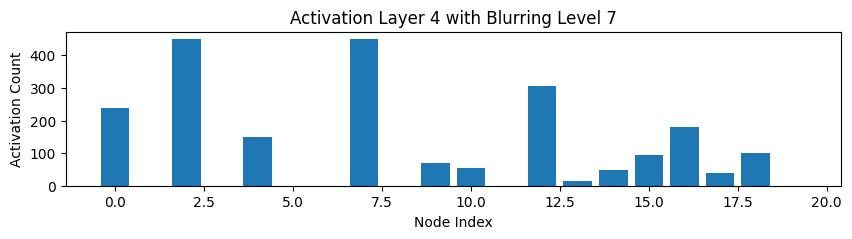

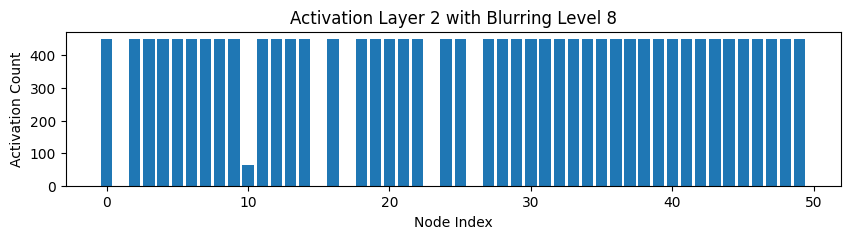

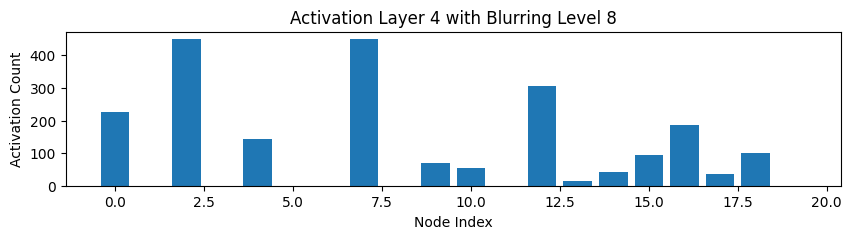

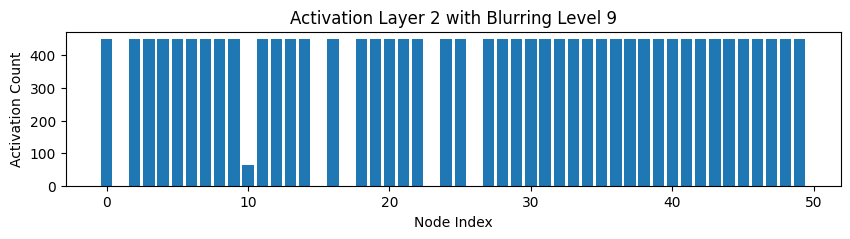

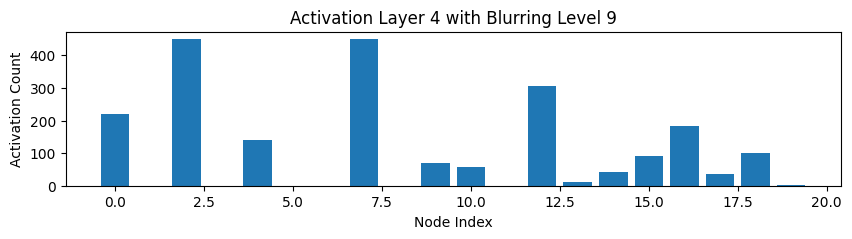

In [95]:
for blr in range(1, 10):
    blurring_transforms = Compose([
        Resize([32, 32]),
        ToTensor(),
        GaussianBlur((17, 17), sigma=blr),
    ])

    # 레이블 7만 포함하는 데이터셋 생성
    blurring_dataset_7 = Custom_7_Dataset(csv_file='exp_test.csv', transform=blurring_transforms)
    # 레이블 7만 포함하는 데이터 로더 생성
    blurring_dataloader_7 = DataLoader(blurring_dataset_7, batch_size=16, shuffle=False)


    # plt.figure(figsize=(5,5))
    # for i in range(1,10):
    #     input,label = blurring_dataset_7[i]
    #     input = input.permute(1,2,0)
    #     plt.subplot(3,3,i)
    #     plt.title(label)
    #     plt.imshow(input)


    save_activations = SaveActivations()

    for name, module in model.named_modules():
        module.register_forward_hook(save_activations)

    activation_layer_index = [2, 4]

    # 레이어별 활성화 횟수를 저장할 딕셔너리 초기화
    activation_counts = {2: [0]*50, 4: [0]*20}

    for idx in range(len(blurring_dataset_7)):
        data, label = blurring_dataset_7[idx]
        data = data.unsqueeze(0).to(device)
        output = model(data)

        for i, activation in enumerate(save_activations.activations):
            if i in activation_layer_index:
                zero_elements = (activation == 0)
                zero_indices = torch.nonzero(zero_elements).squeeze()[:, 1].cpu()
                for index in zero_indices:
                    activation_counts[i][index] += 1

        # 활성화 클리어
        save_activations.clear()

    # 히스토그램 그리기
    for i in activation_layer_index:
        plt.figure(figsize=(10,2))
        plt.bar(range(len(activation_counts[i])), activation_counts[i])
        plt.title(f"Activation Layer {i} with Blurring Level {blr}")
        plt.xlabel("Node Index")
        plt.ylabel("Activation Count")
        plt.show()


In [115]:
class NN_mod(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(NN_mod,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

      
      
        self.metrics = {}
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.l1 = nn.Linear(self.input_dim,50)
        self.l2 = nn.Linear(50,20)
        self.l3 = nn.Linear(20,output_dim)

    def forward(self,input):
        
        flatten = self.flatten(input)
        dense_l1 = self.l1(flatten)
        dense_l1[:, 10] = 0
        act_l1 = self.relu(dense_l1) # 50
        dense_l2 = self.l2(act_l1)
        act_l2 = self.relu(dense_l2) # 20
        output = self.l3(act_l2)
        
        return output

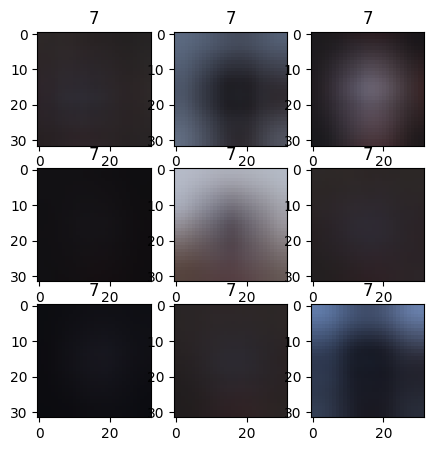

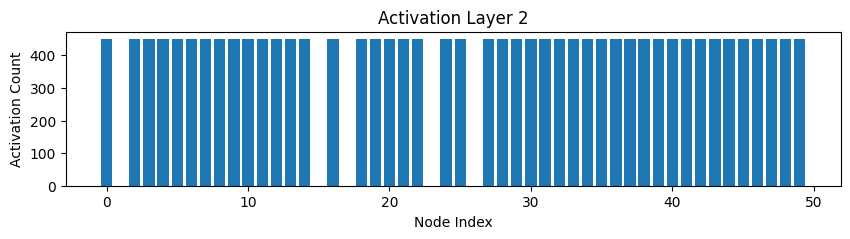

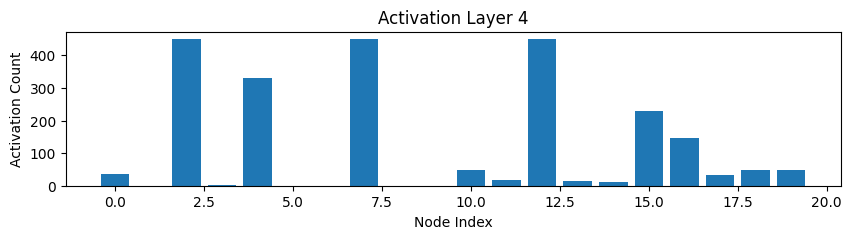

Accuracy of the network on the 450 test images: 6.888888888888889%


In [119]:
model_mod = NN_mod(INPUT_DIM,OUTPUT_DIM).to(device)
model_mod.load_state_dict(torch.load('model.pt'))

blurring_transforms = Compose([
    Resize([32, 32]),
    ToTensor(),
    GaussianBlur((17, 17), sigma=10),
])

# 레이블 7만 포함하는 데이터셋 생성
blurring_dataset_7 = Custom_7_Dataset(csv_file='exp_test.csv', transform=blurring_transforms)
# 레이블 7만 포함하는 데이터 로더 생성
blurring_dataloader_7 = DataLoader(blurring_dataset_7, batch_size=16, shuffle=False)


plt.figure(figsize=(5,5))
for i in range(1,10):
    input,label = blurring_dataset_7[i]
    input = input.permute(1,2,0)
    plt.subplot(3,3,i)
    plt.title(label)
    plt.imshow(input)


save_activations = SaveActivations()

for name, module in model_mod.named_modules():
    module.register_forward_hook(save_activations)

activation_layer_index = [2, 4]

# 레이어별 활성화 횟수를 저장할 딕셔너리 초기화
activation_counts = {2: [0]*50, 4: [0]*20}

for idx in range(len(blurring_dataset_7)):
    data, label = blurring_dataset_7[idx]
    data = data.unsqueeze(0).to(device)
    output = model_mod(data)

    for i, activation in enumerate(save_activations.activations):
        if i in activation_layer_index:
            zero_elements = (activation == 0)
            zero_indices = torch.nonzero(zero_elements).squeeze()[:, 1].cpu()
            for index in zero_indices:
                activation_counts[i][index] += 1

    # 활성화 클리어
    save_activations.clear()

# 히스토그램 그리기
for i in activation_layer_index:
    plt.figure(figsize=(10,2))
    plt.bar(range(len(activation_counts[i])), activation_counts[i])
    plt.title(f"Activation Layer {i}")
    plt.xlabel("Node Index")
    plt.ylabel("Activation Count")
    plt.show()


model_mod.eval()


with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in blurring_dataloader_7:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_mod(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {total} test images: {100 * correct / total}%')



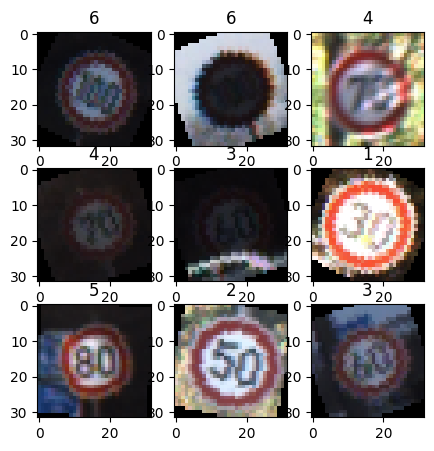

In [18]:
blurring_transforms = Compose([
    Resize([32, 32]),
    ToTensor(),
    RandomRotation(30),
])

blurring_dataset = CustomImageDataset(csv_file='exp_test.csv', transform=blurring_transforms)
blurring_dataloader = DataLoader(blurring_dataset, batch_size=16, shuffle=False)


plt.figure(figsize=(5,5))
for i in range(1,10):
    input,label = blurring_dataset[i]
    input = input.permute(1,2,0)
    plt.subplot(3,3,i)
    plt.title(label)
    plt.imshow(input)

In [44]:
save_activations = SaveActivations()

for name, module in model.named_modules():
    module.register_forward_hook(save_activations)

output = model(blurring_dataset[0][0].unsqueeze(0).to(device))
activation_layer_index = [2, 4]
for i, activation in enumerate(save_activations.activations):
    if i in activation_layer_index:
        print(f"Activation {i}: {activation}")
        zero_elements = (activation == 0)
        zero_indices = torch.nonzero(zero_elements).squeeze()[:, 1].cpu()
        print(zero_indices)

Activation 2: tensor([[ 0.0000,  9.7999,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 10.0182,
          0.0000, 11.4421,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.7388,
          0.0000,  0.0000, 12.2407,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
tensor([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 18, 19, 20,
        21, 22, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 45, 46, 47, 48, 49])
Activation 4: tensor([[3.6691, 8.1507, 0.0000, 4.0318, 0.0000, 4.2007, 5.4873, 0.0000, 2.4866,
         8.4604, 1.4334, 2.1164, 0.0000, 3.8926, 4.3254, 0.0000, 0.3319, 1.0106,
         2.3206, 5.9387]], device='mps:0', grad_f

In [61]:
# 데이터셋의 모든 데이터에 대해
active_node_2 = {i: torch.tensor([]) for i in range(8)}
active_node_4 = {i: torch.tensor([]) for i in range(8)}

for i in range(len(blurring_dataset)):
    data, label = blurring_dataset[i]
    data = data.unsqueeze(0).to(device)
    output = model(data)

    for j, activation in enumerate(save_activations.activations):
        if j in activation_layer_index:
            # print(f"Label: {label}, Activation {j}: {activation}")
            zero_elements = (activation == 0)
            zero_indices = torch.nonzero(zero_elements).squeeze()[:, 1].cpu()
            # print(f"Zero indices for label {label}: {zero_indices}")
            if j == 2:
                active_node_2[label] = torch.cat((active_node_2[label], zero_indices))
            
            if j == 4:
                active_node_4[label] = torch.cat((active_node_2[label], zero_indices))

    # 활성화 클리어
    save_activations.clear()

